In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_convergence_analysis/Invernizzi_Potential/"): print("\nThe data folder \"_data_convergence_analysis/Invernizzi_Potential/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_convergence_analysis/Invernizzi_Potential/"); 
    path_data = path_notebook + "/_data_convergence_analysis/Invernizzi_Potential/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_convergence_analysis/Invernizzi_Potential/


### Define Potential and default parameters

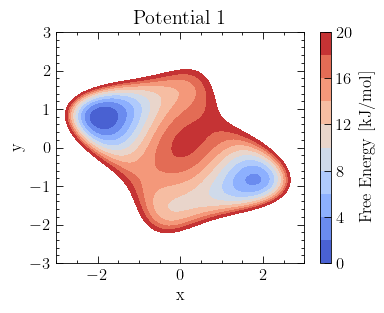

In [2]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
dinve_pot_dy, dinve_pot_dx = np.gradient(inve_pot, grid, grid)
inve_pot_string = "1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598"
plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({inve_pot_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
FES_cutoff = 20

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, inve_pot, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()


In [3]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1], #"dZ_dX":dinve_pot_dx, "dZ_dY":dinve_pot_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text, "plX":plX, "plY":plY, "simulation_steps":1_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.186, 0.186], "metad_height":1, "biasfactor":10,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":100,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":50, "record_forces_e":True, "save_error_progression":False,
                    "simulation_folder_path": path_data, "print_info": False}

### Run 100 Long simulation for reference

In [4]:
# Run 100 long simulations
long_sim_params = {**default_params}
long_sim_params.update({"save_error_progression":True})#, "n_pos":50_000})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1,21):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
    # if 1==2 and os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class2D.MFI2D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad, aBS = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index], MFI_long.Avr_Error_list[:, MFI_long.abs_error_index]
        
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.0760, AAD = 0.2396, ABS = 0.2590
Simulation 2 (exists) | Final Error: Aofe = 1.0727, AAD = 0.2946, ABS = 0.2019
Simulation 3 (exists) | Final Error: Aofe = 1.0676, AAD = 0.2718, ABS = 0.1905
Simulation 4 (exists) | Final Error: Aofe = 1.0641, AAD = 0.2503, ABS = 0.2542
Simulation 5 (exists) | Final Error: Aofe = 1.0632, AAD = 0.3307, ABS = 0.2216
Simulation 6 (exists) | Final Error: Aofe = 1.0822, AAD = 0.3508, ABS = 0.2635
Simulation 7 (exists) | Final Error: Aofe = 1.0678, AAD = 0.4046, ABS = 0.2022
Simulation 8 (exists) | Final Error: Aofe = 1.0710, AAD = 0.2989, ABS = 0.2281
Simulation 9 (exists) | Final Error: Aofe = 1.0651, AAD = 0.4755, ABS = 0.1767
Simulation 10 (exists) | Final Error: Aofe = 1.0768, AAD = 0.3304, ABS = 0.2559
Simulation 11 (exists) | Final Error: Aofe = 1.0719, AAD = 0.5587, ABS = 0.2286
Simulation 12 (exists) | Final Error: Aofe = 1.0843, AAD = 0.5924, ABS = 0.2283
Simulation 13 (exists) | Final Error: Aofe = 1.07

Mean Final AAD: 0.4217 +- 0.0275 || Mean Final ABS: 0.2276 +- 0.0061


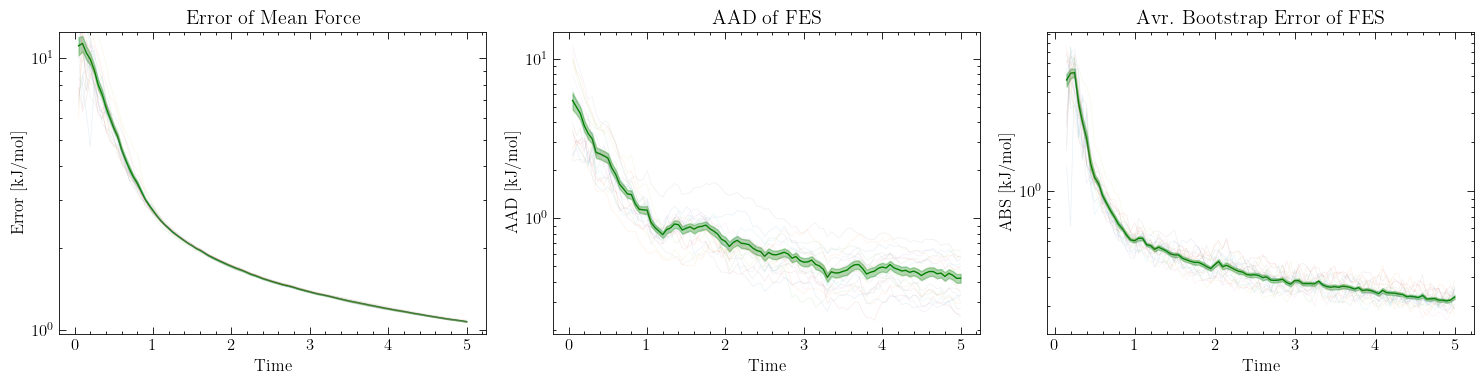

In [6]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                                                                        return_results=True, plot=False, plot_log=True)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
# plt.ylim(0, 20)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f} || Mean Final ABS: {mean_abs_long[-1]:.4f} +- {ste_abs_long[-1]:.4f}")
plt.show()



### Run 100 Exploration simulations

In [23]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":50_000, "metad_height":5, "biasfactor":100, "len_error_list":25})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class2D.MFI2D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad, aBS = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index], MFI_expl.Avr_Error_list[:, MFI_expl.abs_error_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 4.8693, AAD = 1.4701, ABS = 1.3298
Simulation 2 (exists) | Final Error: Aofe = 4.7328, AAD = 1.1776, ABS = 1.0811
Simulation 3 (exists) | Final Error: Aofe = 4.9600, AAD = 1.8727, ABS = 1.6490
Simulation 4 (exists) | Final Error: Aofe = 4.8060, AAD = 1.5782, ABS = 1.6938
Simulation 5 (exists) | Final Error: Aofe = 5.0225, AAD = 1.6876, ABS = 1.5686
Simulation 6 (exists) | Final Error: Aofe = 4.8063, AAD = 1.9437, ABS = 1.2094
Simulation 7 (exists) | Final Error: Aofe = 4.7426, AAD = 1.6507, ABS = 1.8490
Simulation 8 (exists) | Final Error: Aofe = 4.8214, AAD = 1.6959, ABS = 1.2143
Simulation 9 (exists) | Final Error: Aofe = 4.9507, AAD = 2.1925, ABS = 1.4179
Simulation 10 (exists) | Final Error: Aofe = 4.7168, AAD = 2.8625, ABS = 1.5700
Simulation 11 (exists) | Final Error: Aofe = 4.8762, AAD = 2.1620, ABS = 1.3280
Simulation 12 (exists) | Final Error: Aofe = 4.7163, AAD = 1.9261, ABS = 1.1205
Simulation 13 (exists) | Final Error: Aofe = 5.06

Mean Final AAD: 2.0282 +- 0.0624, Mean Final ABS: 1.4901 +- 0.0298


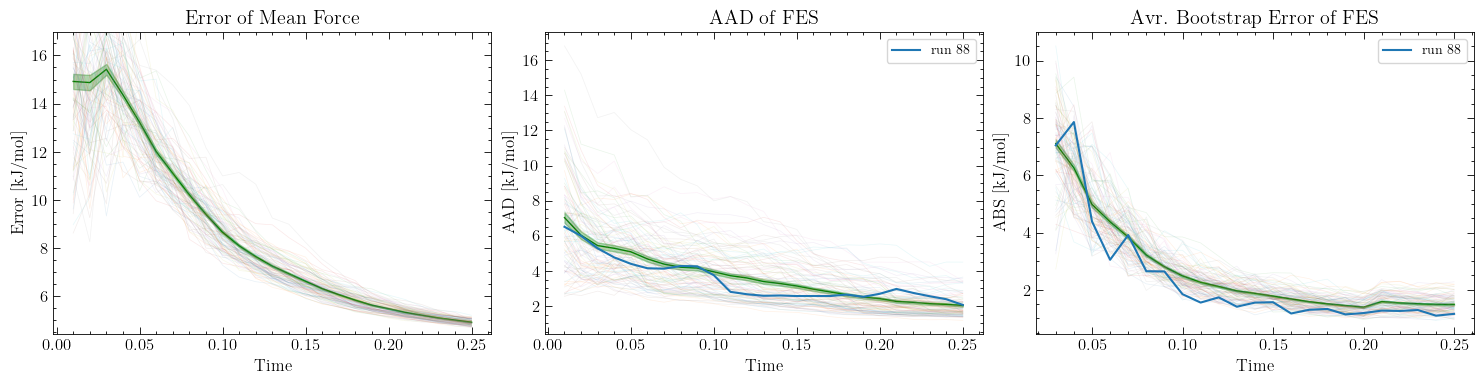

In [24]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                                                                        return_results=True, plot=False, plot_log=False)
time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl, mean_abs_expl, ste_abs_expl = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}, Mean Final ABS: {mean_abs_expl[-1]:.4f} +- {ste_abs_expl[-1]:.4f}")

plt.subplot(1,3,2); plt.plot(t, aad_collection[88], label="run 88"); plt.legend(fontsize=10)
plt.subplot(1,3,3); plt.plot(t, abs_collection[88], label="run 88"); plt.legend(fontsize=10)
plt.show()


Final Error: Aofe = 5.0192, AAD = 2.0979
MIN(FES+Bias) = 21.4979, MIN(Z+Bias) = 19.9870


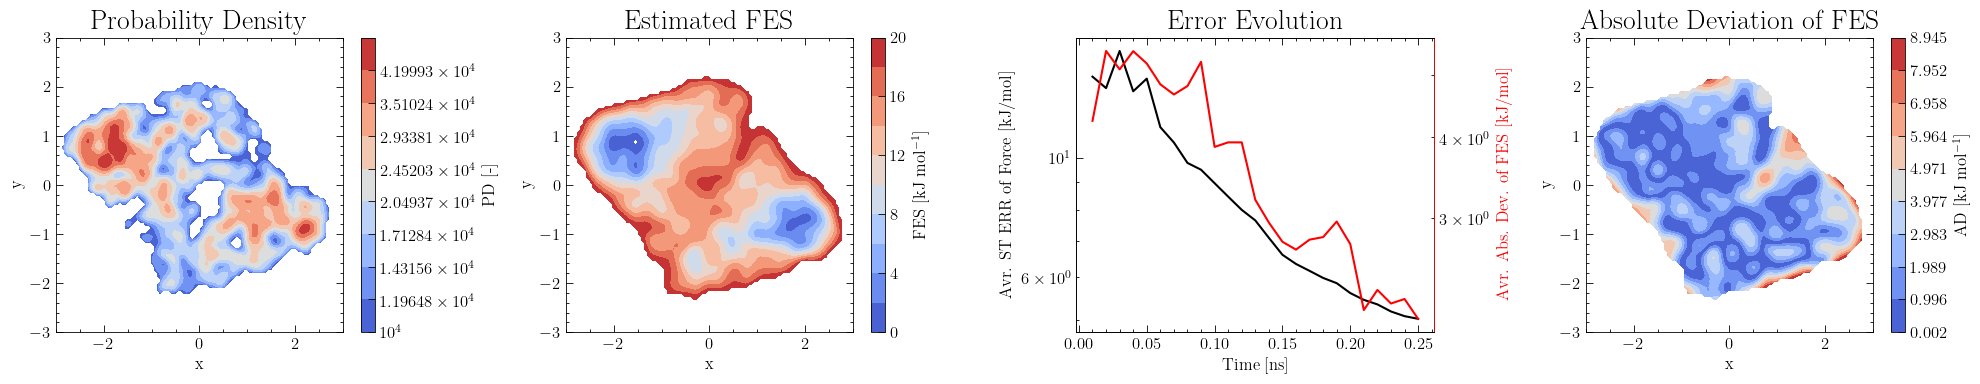

ready to show


In [5]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
new_params.update({"ID":"_expl_88", "len_error_list":25, "save_results":True})

MFI_expl = MFI_class2D.MFI2D(**new_params)
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(inve_pot + MFI_expl.Bias):.4f}")

MFI_expl.plot_res(["AD"])
lib2.plot_3D_plotly(MFI_expl.X, MFI_expl.Y, MFI_expl.Z + MFI_expl.Bias, range_min=0, range_max=np.min(inve_pot + MFI_expl.Bias)*2)
t_expl, v_expl, aofe_expl, aad_expl, abs_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index], MFI_expl.Avr_Error_list[:, MFI_expl.abs_error_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES
forces_e_list_expl = MFI_expl.forces_e_list


### 2nd Stage - 1x MetaD simulation

In [9]:
## laod results from the exploration simulation
res = lib2.load_pkl(path_data + f"MFI_results_expl_88.pkl")[1]
force_terms_expl = res[0]
fes_expl = lib2.FFT_intg_2D(_force_terms_expl[2], _force_terms_expl[3], [-3,-3], [3, 3])
sim_time_expl = res[1].T[0][-1]
forces_e_list_expl = res[-1]


(5, 25)


In [8]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":950_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.0831, AAD = 0.3859, ABS = 0.2355
Simulation 2 (exists) | Final Error: Aofe = 1.0884, AAD = 0.4126, ABS = 0.2494
Simulation 3 (exists) | Final Error: Aofe = 1.0897, AAD = 0.4418, ABS = 0.2533
Simulation 4 (exists) | Final Error: Aofe = 1.0797, AAD = 0.4619, ABS = 0.2257
Simulation 5 (exists) | Final Error: Aofe = 1.0900, AAD = 0.4565, ABS = 0.2113
Simulation 6 (exists) | Final Error: Aofe = 1.0929, AAD = 0.5190, ABS = 0.2456
Simulation 7 (exists) | Final Error: Aofe = 1.0866, AAD = 0.4003, ABS = 0.2121
Simulation 8 (exists) | Final Error: Aofe = 1.0817, AAD = 0.6440, ABS = 0.2406
Simulation 9 (exists) | Final Error: Aofe = 1.0915, AAD = 0.4485, ABS = 0.1986
Simulation 10 (exists) | Final Error: Aofe = 1.0959, AAD = 0.3882, ABS = 0.2643
Simulation 11 (exists) | Final Error: Aofe = 1.0820, AAD = 0.4697, ABS = 0.2331
Simulation 12 (exists) | Final Error: Aofe = 1.0927, AAD = 0.3927, ABS = 0.2371
Simulation 13 (exists) | Final Error: Aofe = 1.08

Mean Final AAD: 0.4471 +- 0.0057 || Mean Final ABS: 0.2349 +- 0.0019


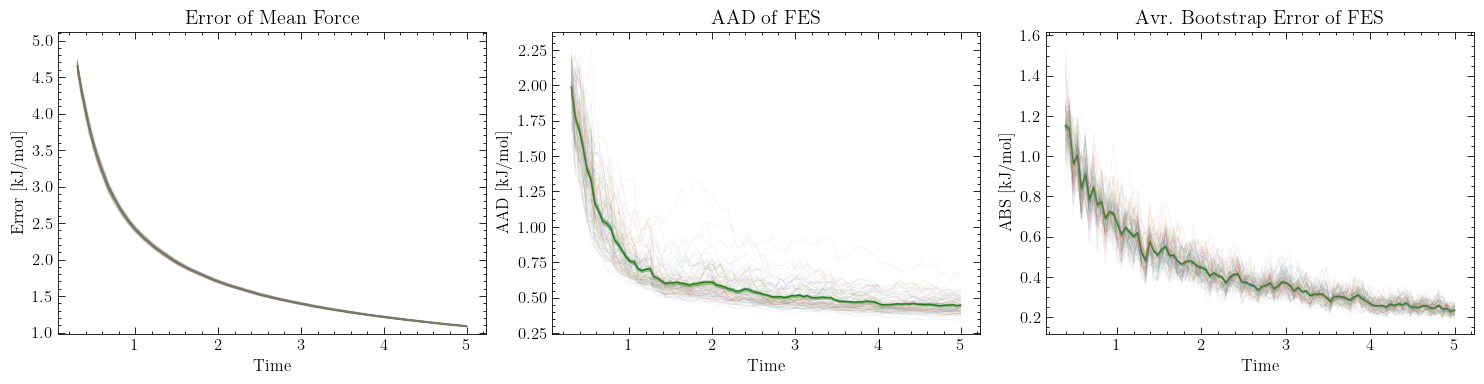

In [9]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, 
                                                return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results

plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f} || Mean Final ABS: {mean_abs_metad[-1]:.4f} +- {ste_abs_metad[-1]:.4f}")
plt.show()

In [10]:
# Run 100 MetaD ALTERNATIVE simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":950_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
metad_sim_params.update({"base_forces":None, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_metad_{i_sim}"
    sim_ID_ALT = f"_metadALT_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID_ALT}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID_ALT}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.ID = sim_ID_ALT
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.0874, AAD = 0.3850, ABS = 0.2032
Simulation 2 (exists) | Final Error: Aofe = 1.0917, AAD = 0.3998, ABS = 0.1982
Simulation 3 (exists) | Final Error: Aofe = 1.0940, AAD = 0.4223, ABS = 0.2345
Simulation 4 (exists) | Final Error: Aofe = 1.0826, AAD = 0.4245, ABS = 0.2056
Simulation 5 (exists) | Final Error: Aofe = 1.0918, AAD = 0.4122, ABS = 0.1897
Simulation 6 (exists) | Final Error: Aofe = 1.0970, AAD = 0.4648, ABS = 0.1927
Simulation 7 (exists) | Final Error: Aofe = 1.0896, AAD = 0.3936, ABS = 0.2076
Simulation 8 (exists) | Final Error: Aofe = 1.0841, AAD = 0.5921, ABS = 0.1864
Simulation 9 (exists) | Final Error: Aofe = 1.0949, AAD = 0.4172, ABS = 0.1876
Simulation 10 (exists) | Final Error: Aofe = 1.1002, AAD = 0.4051, ABS = 0.1881
Simulation 11 (exists) | Final Error: Aofe = 1.0862, AAD = 0.4312, ABS = 0.2004
Simulation 12 (exists) | Final Error: Aofe = 1.0957, AAD = 0.3931, ABS = 0.2050
Simulation 13 (exists) | Final Error: Aofe = 1.09

Mean Final AAD: 0.4207 +- 0.0047  || Mean Final ABS: 0.1985 +- 0.0018


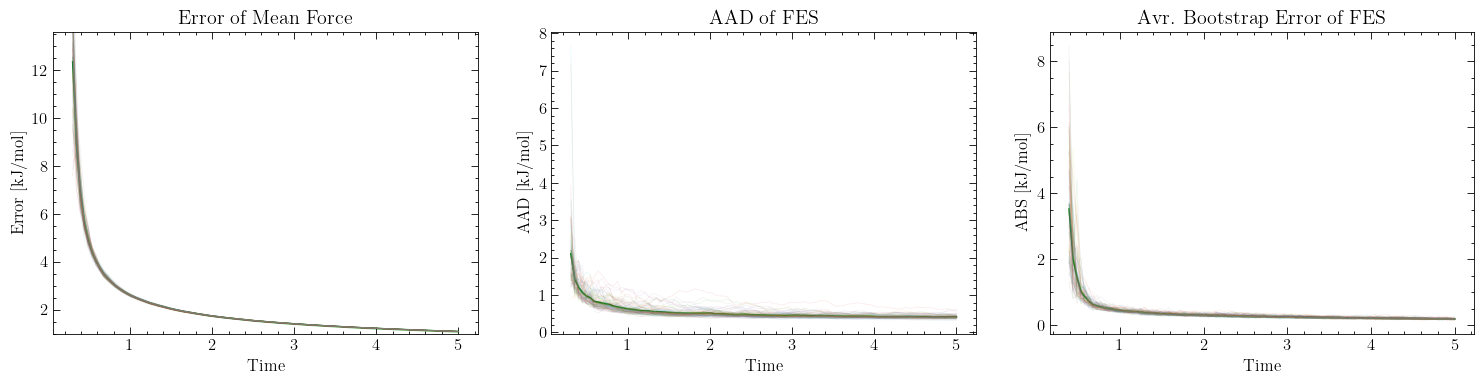

In [11]:
# Statistical Analysis of 100 MetaD ALTERNATIVE simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadALT[-1]:.4f} +- {ste_aad_metadALT[-1]:.4f}  || Mean Final ABS: {mean_abs_metadALT[-1]:.4f} +- {ste_abs_metadALT[-1]:.4f}")
plt.show()

### 2nd Stage - 2x MetaD simulations

In [12]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"simulation_steps":750_000, "len_error_list":360})#, "n_pos":35_625}) # 
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.8847, AAD = 0.4011, ABS = 0.2070
Analysis 2 (exists) | Final Error: Aofe = 0.8826, AAD = 0.4400, ABS = 0.2185
Analysis 3 (exists) | Final Error: Aofe = 0.8941, AAD = 0.4552, ABS = 0.1678
Analysis 4 (exists) | Final Error: Aofe = 0.8824, AAD = 0.4013, ABS = 0.2137
Analysis 5 (exists) | Final Error: Aofe = 0.8909, AAD = 0.3749, ABS = 0.2364
Analysis 6 (exists) | Final Error: Aofe = 0.8840, AAD = 0.4022, ABS = 0.1792
Analysis 7 (exists) | Final Error: Aofe = 0.8834, AAD = 0.3865, ABS = 0.2100
Analysis 8 (exists) | Final Error: Aofe = 0.8842, AAD = 0.4325, ABS = 0.2091
Analysis 9 (exists) | Final Error: Aofe = 0.8833, AAD = 0.4324, ABS = 0.1566
Analysis 10 (exists) | Final Error: Aofe = 0.8850, AAD = 0.3915, ABS = 0.2268
Analysis 11 (exists) | Final Error: Aofe = 0.8908, AAD = 0.3927, ABS = 0.2146
Analysis 12 (exists) | Final Error: Aofe = 0.8909, AAD = 0.4873, ABS = 0.2296
Analysis 13 (exists) | Final Error: Aofe = 0.8896, AAD = 0.4199, ABS = 0.

Mean Final AAD: 0.4171 +- 0.0062 || Mean Final ABS: 0.2077 +- 0.0036


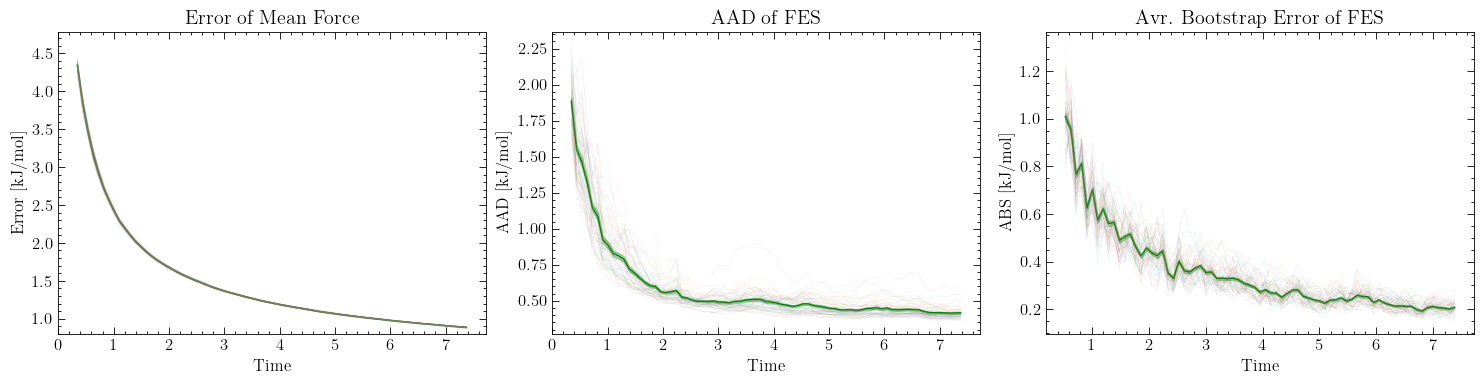

In [13]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2, mean_abs_metadx2, ste_abs_metadx2 = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f} || Mean Final ABS: {mean_abs_metadx2[-1]:.4f} +- {ste_abs_metadx2[-1]:.4f}")
plt.show()

In [14]:
# Patching of 50x2 MetaDERNATIVE simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"simulation_steps":750_000, "len_error_list":360})#, "n_pos":35_625}) # 
metadx2_sim_params.update({"base_forces":None, "base_time":sim_time_expl, "base_forces_e_list":None})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2ALT_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.8869, AAD = 0.4079, ABS = 0.1836
Analysis 2 (exists) | Final Error: Aofe = 0.8849, AAD = 0.4208, ABS = 0.1838
Analysis 3 (exists) | Final Error: Aofe = 0.8963, AAD = 0.4259, ABS = 0.1515
Analysis 4 (exists) | Final Error: Aofe = 0.8842, AAD = 0.3848, ABS = 0.1728
Analysis 5 (exists) | Final Error: Aofe = 0.8926, AAD = 0.3709, ABS = 0.1765
Analysis 6 (exists) | Final Error: Aofe = 0.8860, AAD = 0.3905, ABS = 0.1696
Analysis 7 (exists) | Final Error: Aofe = 0.8859, AAD = 0.3833, ABS = 0.1650
Analysis 8 (exists) | Final Error: Aofe = 0.8862, AAD = 0.4481, ABS = 0.1864
Analysis 9 (exists) | Final Error: Aofe = 0.8855, AAD = 0.4036, ABS = 0.1598
Analysis 10 (exists) | Final Error: Aofe = 0.8872, AAD = 0.3901, ABS = 0.1589
Analysis 11 (exists) | Final Error: Aofe = 0.8931, AAD = 0.3647, ABS = 0.1570
Analysis 12 (exists) | Final Error: Aofe = 0.8934, AAD = 0.4542, ABS = 0.2054
Analysis 13 (exists) | Final Error: Aofe = 0.8922, AAD = 0.3937, ABS = 0.

Mean Final AAD: 0.4171 +- 0.0062 || Mean Final ABS: 0.2077 +- 0.0036


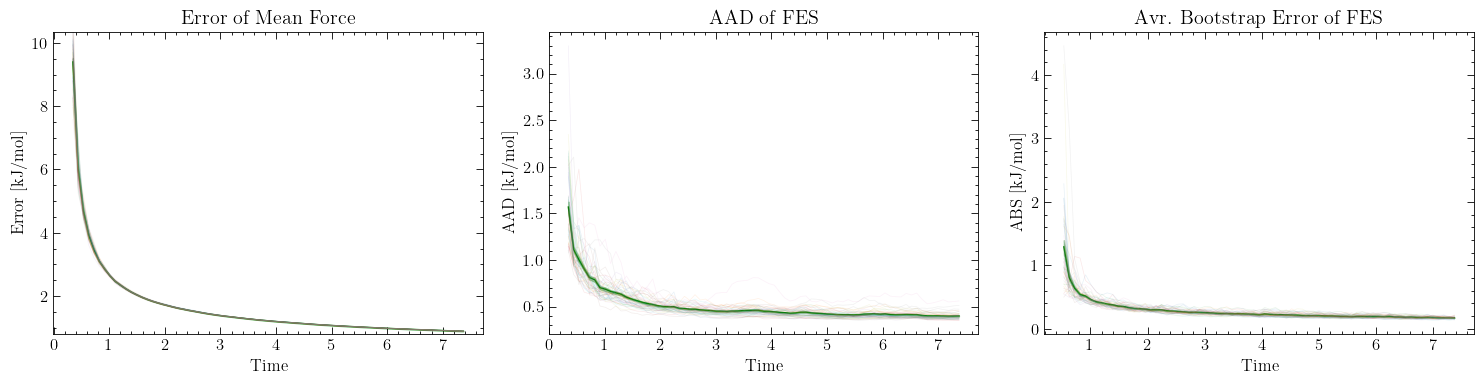

In [15]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadx2ALT, mean_ofe_metadx2ALT, ste_ofe_metadx2ALT, mean_aad_metadx2ALT, ste_aad_metadx2ALT, mean_abs_metadx2ALT, ste_abs_metadx2ALT = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f} || Mean Final ABS: {mean_abs_metadx2[-1]:.4f} +- {ste_abs_metadx2[-1]:.4f}")
plt.show()

### 2nd Stage - 3x MetaD simulations

In [52]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 3
parallel_efficiency = 0.667

# for n_camp in range(1, 34):
for n_camp in range(9, 34): ### first 8 are already done with ABS calculations
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    # if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
    if 1==2 and os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class2D.MFI2D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,1], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Analysis 2 | Final Error: Aofe = 0.7716, AAD = 0.4870, ABS = 0.2126
Analysis 3 | Final Error: Aofe = 0.7679, AAD = 0.4280, ABS = 0.2112
Analysis 4 | Final Error: Aofe = 0.7708, AAD = 0.3809, ABS = 0.1708
Analysis 5 | Final Error: Aofe = 0.7674, AAD = 0.3948, ABS = 0.1640
Analysis 6 | Final Error: Aofe = 0.7682, AAD = 0.4389, ABS = 0.1697
Analysis 7 | Final Error: Aofe = 0.7719, AAD = 0.3749, ABS = 0.1897
Analysis 8 | Final Error: Aofe = 0.7717, AAD = 0.4267, ABS = 0.1667
Analysis 9 | 

KeyboardInterrupt: 

Mean Final AAD: 0.4193 +- 0.0073


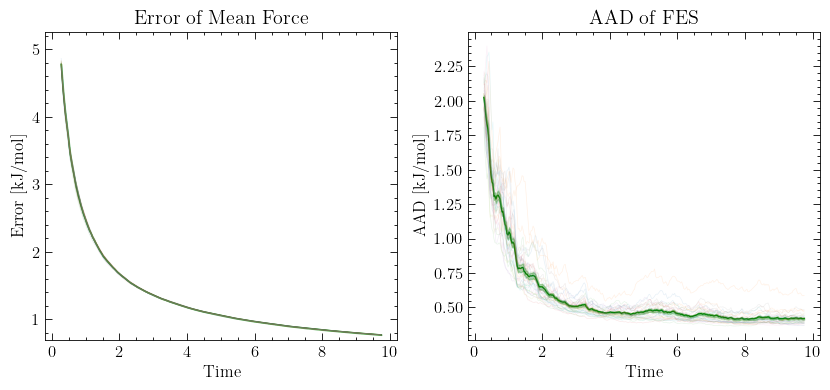

In [ ]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3, mean_abs_metadx3, ste_abs_metadx3 = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f} || Mean Final ABS: {mean_abs_metadx3[-1]:.4f} +- {ste_abs_metadx3[-1]:.4f}")
plt.show()

In [ ]:
# # Patching of 33x3 MetaD ALTERNATIVE simulations
# metadx3_sim_params = {**default_params}
# metadx3_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
# metadx3_sim_params.update({"base_forces":None, "base_time":sim_time_expl, "base_forces_e_list":None})

# t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

# n_parallel = 3
# parallel_efficiency = 0.667

# for n_camp in range(1, 34):
    
#     camp_ID = f"_metadx3ALT_{n_camp}"
#     new_params.update({"ID":camp_ID})
    
#     # if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
#     if 1==2 and os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
#         print(f"Analysis {n_camp} (exists)", end=" | ")
#         t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
#     else:   
#         print(f"Analysis {n_camp}", end=" | ")

#         MFI_metadx3 = MFI_class2D.MFI2D(**metadx3_sim_params)
#         MFI_metadx3.make_external_bias(FES=fes_expl)
#         mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

#         camp_sim = 0
#         for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
#             res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
#             mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
#             mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
#             camp_sim += 1 

#         mfi_parallel_x3.patch_simulations()
#         t, v, aofe, aad, aBS = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,1], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.abs_error_index]
#         lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

#     t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
#     print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


### 2nd Stage - 4x MetaD simulations

In [15]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
# metadx4_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class2D.MFI2D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 (exists) | Final Error: Aofe = 0.7578, AAD = 0.4426
Analysis 2 (exists) | Final Error: Aofe = 0.7598, AAD = 0.4279
Analysis 3 (exists) | Final Error: Aofe = 0.7595, AAD = 0.3953
Analysis 4 (exists) | Final Error: Aofe = 0.7548, AAD = 0.4275
Analysis 5 (exists) | Final Error: Aofe = 0.7582, AAD = 0.4129
Analysis 6 (exists) | Final Error: Aofe = 0.7624, AAD = 0.3865
Analysis 7 (exists) | Final Error: Aofe = 0.7571, AAD = 0.3914
Analysis 8 (exists) | Final Error: Aofe = 0.7584, AAD = 0.4030
Analysis 9 (exists) | Final Error: Aofe = 0.7598, AAD = 0.5444
Analysis 10 (exists) | Final Error: Aofe = 0.7583, AAD = 0.4012
Analysis 11 (exists) | Final Error: Aofe = 0.7617, AAD = 0.4234
Analysis 12 (exists) | Final Error: Aofe = 0.7580, AAD = 0.4215
Analysis 13 (exists) | Final Error: Aofe = 0.7568, AAD = 0.3936
Analysis 14 (exists) | Final Error: Aofe = 0.7612, AAD = 0.4003
Analysis 15 (exists) | Final Error: Aofe = 0.7571, AAD = 0.4410
Analysis 16 (exists) | Final Error: Aofe = 0.7547

Mean Final AAD: 0.4115 +- 0.0069


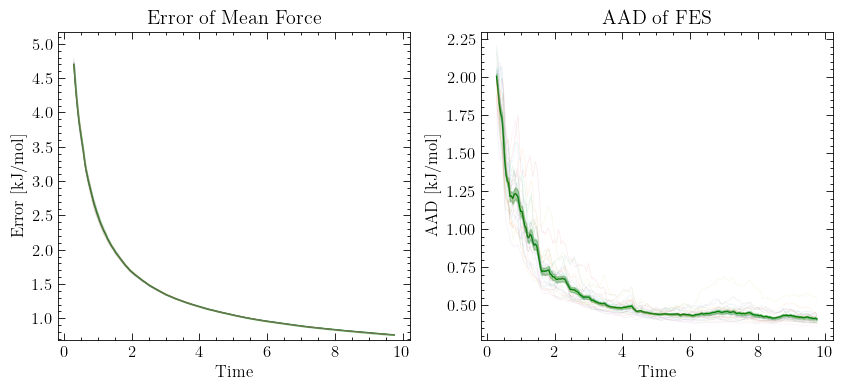

In [16]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [17]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
# metadx6_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class2D.MFI2D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.6889, AAD = 0.4595
Analysis 2 (exists) | Final Error: Aofe = 0.6884, AAD = 0.4704
Analysis 3 (exists) | Final Error: Aofe = 0.6851, AAD = 0.3912
Analysis 4 (exists) | Final Error: Aofe = 0.6923, AAD = 0.4045
Analysis 5 (exists) | Final Error: Aofe = 0.6876, AAD = 0.4200
Analysis 6 (exists) | Final Error: Aofe = 0.6892, AAD = 0.5372
Analysis 7 (exists) | Final Error: Aofe = 0.6896, AAD = 0.4487
Analysis 8 (exists) | Final Error: Aofe = 0.6875, AAD = 0.4302
Analysis 9 (exists) | Final Error: Aofe = 0.6904, AAD = 0.4136
Analysis 10 (exists) | Final Error: Aofe = 0.6872, AAD = 0.4088
Analysis 11 (exists) | Final Error: Aofe = 0.6864, AAD = 0.4455
Analysis 12 (exists) | Final Error: Aofe = 0.6910, AAD = 0.3746
Analysis 13 (exists) | Final Error: Aofe = 0.6894, AAD = 0.3840
Analysis 14 (exists) | Final Error: Aofe = 0.6885, AAD = 0.4054
Analysis 15 (exists) | Final Error: Aofe = 0.6884, AAD = 0.3925
Analysis 16 (exists) | Final Error: Aofe = 0.6854

Mean Final AAD: 0.4266 +- 0.0098


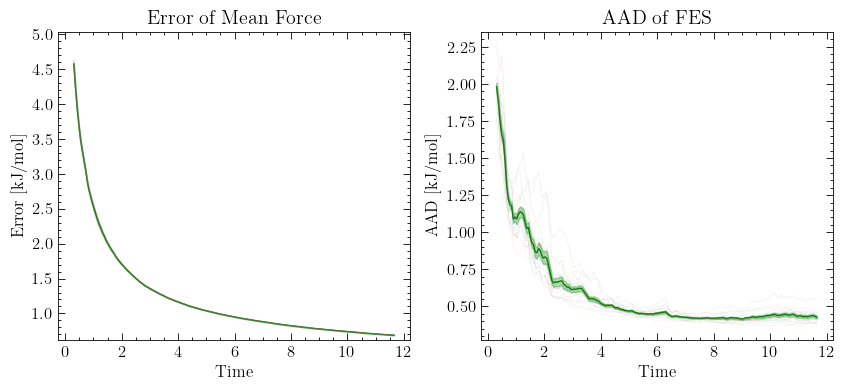

In [18]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx6[-1]:.4f} +- {ste_aad_metadx6[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [19]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
# metadx10_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class2D.MFI2D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.6115, AAD = 0.4377
Analysis 2 (exists) | Final Error: Aofe = 0.6096, AAD = 0.3990
Analysis 3 (exists) | Final Error: Aofe = 0.6105, AAD = 0.3979
Analysis 4 (exists) | Final Error: Aofe = 0.6114, AAD = 0.4074
Analysis 5 (exists) | Final Error: Aofe = 0.6133, AAD = 0.4414
Analysis 6 (exists) | Final Error: Aofe = 0.6107, AAD = 0.3878
Analysis 7 (exists) | Final Error: Aofe = 0.6110, AAD = 0.3828
Analysis 8 (exists) | Final Error: Aofe = 0.6139, AAD = 0.3802
Analysis 9 (exists) | Final Error: Aofe = 0.6112, AAD = 0.3913
Analysis 10 (exists) | Final Error: Aofe = 0.6113, AAD = 0.3948


Mean Final AAD: 0.4020 +- 0.0064


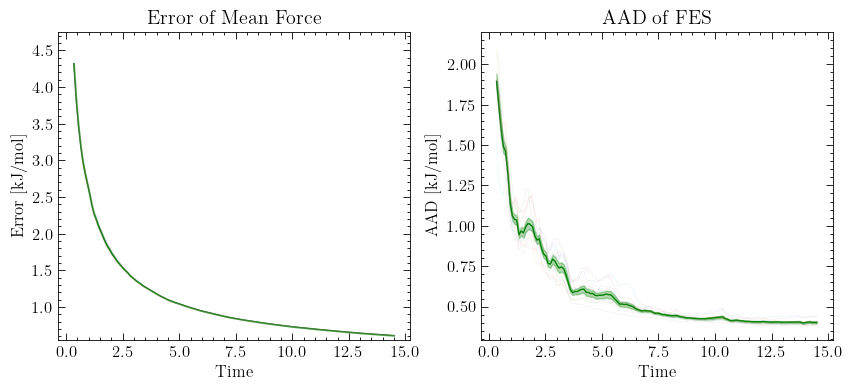

In [20]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx10[-1]:.4f} +- {ste_aad_metadx10[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [16]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data


NameError: name 'time_metadx2' is not defined

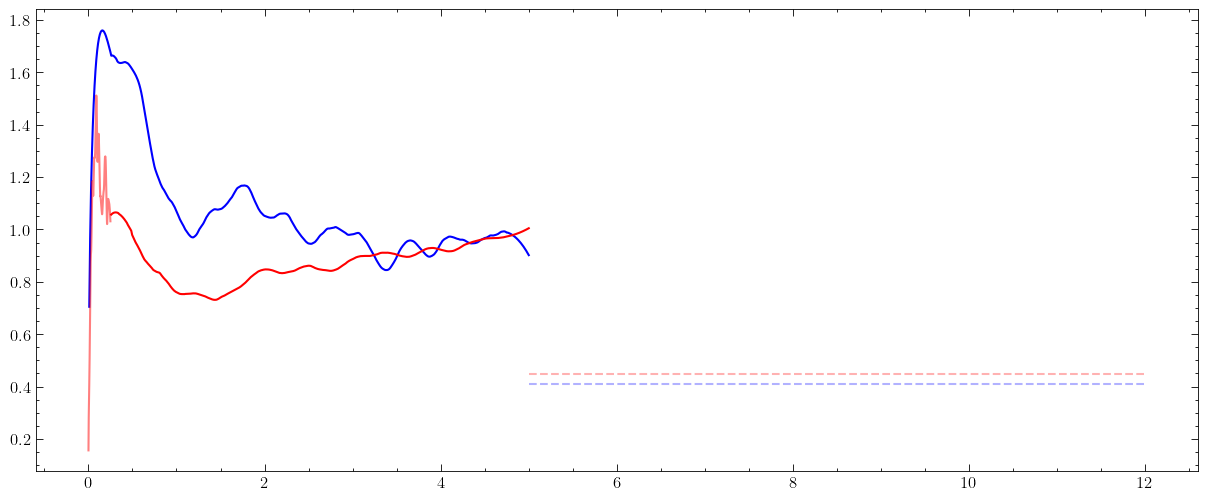

In [16]:
plt.figure(figsize=(15,6))
# plt.figure(figsize=(20,4))
# # time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

# plt.subplot(1,2,1)
# plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# # plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# # plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# # plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
# plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

# plt.subplot(1,2,2)
plt.plot(time_long, np.sqrt(time_long)*sf(mean_aad_long), label="Long", color="blue"); plt.plot([time_long[-1], 12], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, np.sqrt(t_expl)*sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, np.sqrt(time_metad)*sf(mean_aad_metad), label="MetaD", color="red"); plt.plot([time_metad[-1], 12], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, np.sqrt(time_metadx2)*sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
plt.plot(time_metadx4, np.sqrt(time_metadx4)*sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, np.sqrt(time_metadx10)*mean_aad_metadx10, label="MetaDx10", color="grey")

# plt.ylim(0.38, 3)
# plt.xlim(0, 5)
# plt.yscale("log"); 
plt.legend(); plt.title("Comparison of AAD"); plt.show()

In [11]:
### laod results

# long simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,21):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_long_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.close()

# exploration simulation
t_expl, _, aofe_expl, aad_expl, abs_expl = lib2.load_pkl(path_data + f"MFI_results_expl_88.pkl")[1][1].T

# metad simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,101):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metad_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results
plt.close()

# metad ALTERNATIVE simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,101):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadALT_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.close()

# metadx2 ALTERNATIVE simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,51):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadx2_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2, mean_abs_metadx2, ste_abs_metadx2 = avr_results
plt.close()

# metadx2 ALTERNATIVE simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,51):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadx2ALT_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metadx2ALT, mean_ofe_metadx2ALT, ste_ofe_metadx2ALT, mean_aad_metadx2ALT, ste_aad_metadx2ALT, mean_abs_metadx2ALT, ste_abs_metadx2ALT = avr_results
plt.close()

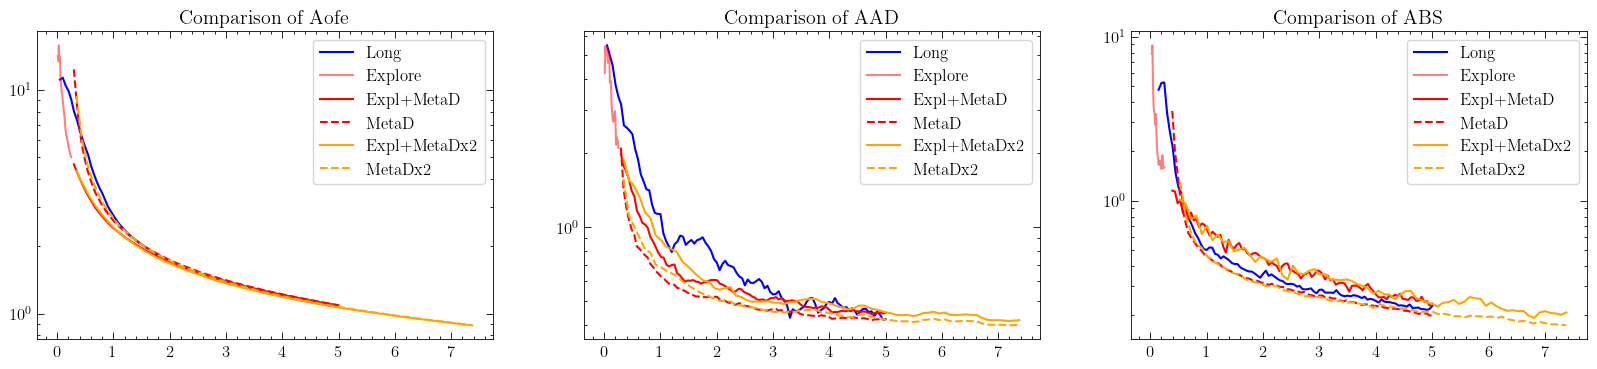

In [12]:
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data

plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,3,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="Expl+MetaD", color="red")
plt.plot(time_metadALT, mean_ofe_metadALT, label="MetaD", color="red", linestyle="--")
plt.plot(time_metadx2, mean_ofe_metadx2, label="Expl+MetaDx2", color="orange")
plt.plot(time_metadx2, mean_ofe_metadx2ALT, label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,3,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="Expl+MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_aad_metadALT), label="MetaD", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3, linestyle="--")
plt.plot(time_metadx2, sf(mean_aad_metadx2), label="Expl+MetaDx2", color="orange")
plt.plot(time_metadx2, sf(mean_aad_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); 
# plt.ylim(0.38, 0.6); 
# plt.xlim(0,10)

plt.subplot(1,3,3)
plt.plot(time_long, sf(mean_abs_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t_expl, abs_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_abs_metad), label="Expl+MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_abs_metadALT), label="MetaD", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3, linestyle="--")
plt.plot(time_metadx2, sf(mean_abs_metadx2), label="Expl+MetaDx2", color="orange")
plt.plot(time_metadx2, sf(mean_abs_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_abs_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_abs_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_abs_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_abs_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of ABS"); 
# plt.ylim(0.38, 0.6); 
# plt.xlim(0,10)

plt.show()
